<a href="https://colab.research.google.com/github/Chloe0704/Reproduce_physioMTL/blob/main/Reproduce_physioMTL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!git clone https://github.com/hichamjanati/mutar
%cd mutar
!pip install -e .
%cd /content

%pip install pot
%pip install hwcounter

import site
site.main()


Cloning into 'mutar'...
remote: Enumerating objects: 916, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 916 (delta 8), reused 16 (delta 7), pack-reused 899 (from 1)
Receiving objects: 100% (916/916), 1.72 MiB | 13.35 MiB/s, done.
Resolving deltas: 100% (495/495), done.
/content/mutar
Obtaining file:///content/mutar
  Preparing metadata (setup.py) ... done
  Running setup.py develop for mutar
/content
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for hwcounter: filename=hwcounter-0.1.1-cp311-cp311-linux_x86_64.whl size=11845 sha256=4bf57c5d197a64ae88d71ebad12ae77bc08e7c0fbefc86f22f8278581ff78038
  Stored in directory: /root/.cache/pip/wheels/17/90/05/59b45e247f09430a406292de15430e53c83dc934e68a0a2fc3
Successfully built hwcounter


In [88]:
# Evaluation of computational requirements, hardware logging, etc.
import platform
import socket
import re
import uuid
import json
import psutil
import logging

# Regression methods
import zipfile
import numpy as np
import pandas as pd
import ot
import matplotlib.cm as cm
import random
import mutar
from mutar import GroupLasso, DirtyModel, MTW, MultiLevelLasso, ReMTW
from hwcounter import Timer, count, count_end
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import table

In [22]:
def get_size(bytes):
    bucket = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < bucket:
            return f"{bytes:.2f}{unit}B"
        bytes /= bucket

def get_memory_utilization():
    svmem = psutil.virtual_memory()
    return {
        'Memory (Total)': f'{get_size(svmem.total)}',
        'Memory (Available)': f'{get_size(svmem.available)}',
        'Memory (Used)': f'{get_size(svmem.used)}',
        'Memory Utilization': f'{svmem.percent}%'
    }

def get_system_info():
    svmem = psutil.virtual_memory()
    return {
        'Platform': platform.system(),
        'Architecture': platform.machine(),
        'Processor': platform.processor(),
        'RAM': f'{round(psutil.virtual_memory().total / (1024 ** 3), 3)} GB',
        'CPU Cores (Physical)': psutil.cpu_count(logical=False),
        'CPU Cores (Total)': psutil.cpu_count(logical=True)
    } | get_memory_utilization()

def get_cpu_seconds(cycles):
    return cycles / psutil.cpu_count(logical=True) / 1000000000

print(get_system_info())

{'Platform': 'Linux', 'Architecture': 'x86_64', 'Processor': 'x86_64', 'RAM': '12.674 GB', 'CPU Cores (Physical)': 1, 'CPU Cores (Total)': 2, 'Memory (Total)': '12.67GB', 'Memory (Available)': '11.23GB', 'Memory (Used)': '1.15GB', 'Memory Utilization': '11.4%'}


# MMASH

In [ ]:
!mkdir MMASH
!mkdir Data
!mkdir Data/figures
!wget -O MMASH/mmash.zip -r -N -c -np https://physionet.org/files/mmash/1.0.0/MMASH.zip

with zipfile.ZipFile('MMASH/mmash.zip', 'r') as zip_ref:
  zip_ref.extractall('MMASH')

!rm MMASH/mmash.zip

## Preprocess MMASH


In [40]:
# Scripting constants
BASELINE_DATES = {1: "2020-08-01", 2: "2020-08-02"}
RANDOM_STATE = 12345
USER_FILE_PREFIX = "/content/MMASH/DataPaper/user_"
TASKS = range(1, 23)

# Data set variables
RELEVANT_ACTIVITY = [4, 5]
USER_INFO_FIELDS = ["Age", "Height", "Weight"]
OMIT_TASKS = [4,]
OVERWRITES = {3: [5,60], 11: [4,6.5], 18: [0,22]}
RAD_HOUR = 2.0 * np.pi / 24

# Pre-processing hyperparameters
IBIS_UPPER = 2.1
IBIS_LOWER = 0.3
FREQUENCY = "5min"
NOISE_UPPER = 55.0
NOISE_SAMPLE_PERCENT = 0.85

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import table

In [12]:
class MMASH:
    def __init__(self, tasks, max_zscore, max_noise=NOISE_UPPER, show_plots=True):
        self.max_zscore = max_zscore
        if self.max_zscore is None:
            self.max_zscore = 999999
        self.max_noise = max_noise
        self.X, self.S, self.Y = [], [], []
        self.start_processing_cycles = count()
        self.show_plots = show_plots

        # Data collection for combined visualization
        self.all_sleep_data = []
        self.all_activity_data = []
        self.all_user_info = []
        self.all_questionnaire = []
        self.all_rr_data = []
        self.processed_rr_data = []

        for i in tasks:
            i_start = count()
            user_folder = USER_FILE_PREFIX + str(i)

            # Load all data
            sleep_data = pd.read_csv(user_folder + "/sleep.csv")
            activity_data = pd.read_csv(user_folder + "/Activity.csv", header=0)
            user_info_data = pd.read_csv(user_folder + "/user_info.csv", header=0)
            questionnaire_data = pd.read_csv(user_folder + "/questionnaire.csv", header=0)
            rr_data = pd.read_csv(user_folder + "/RR.csv", header=0)

            # Store raw data for combined visualization
            sleep_data['user'] = i
            activity_data['user'] = i
            user_info_data['user'] = i
            questionnaire_data['user'] = i
            rr_data['user'] = i

            self.all_sleep_data.append(sleep_data)
            self.all_activity_data.append(activity_data)
            self.all_user_info.append(user_info_data)
            self.all_questionnaire.append(questionnaire_data)
            self.all_rr_data.append(rr_data)

            # Process data
            sleep_value = self.get_sleep_data(sleep_data)
            activity_value = self.get_activity_data(activity_data)
            user_info_value = self.get_user_info_data(user_info_data)
            questionnaire_value = self.get_questionnaire_data(questionnaire_data)
            rr_value = self.get_rr_data(rr_data)
            self.processed_rr_data.append(rr_value.assign(user=i))

            t_hour = rr_value["t_hour"].values
            s_vector = np.hstack([user_info_value, activity_value, sleep_value, questionnaire_value])
            if i in OVERWRITES:
                s_vector[OVERWRITES[i][0]] = OVERWRITES[i][1]

            self.X.append(np.asarray([np.sin(RAD_HOUR * t_hour), np.cos(RAD_HOUR * t_hour), np.ones(t_hour.shape[0], )]).T)
            self.S.append(s_vector.reshape(-1, 1))
            self.Y.append(rr_value["value"].values.reshape((-1, 1)))

            i_cycles = count_end() - i_start
            print(f'{i}: preprocessed task, y-mean = {rr_value["value"].mean()}, elapsed time: {i_cycles} cycles ({get_cpu_seconds(i_cycles)} seconds)')

        self.X = np.asarray(self.X, dtype=object)
        self.S = np.asarray(self.S)
        self.Y = np.asarray(self.Y, dtype=object)
        self.elapsed_processing_cycles = count_end() - self.start_processing_cycles

        # Combine all data for visualization
        if self.show_plots and tasks:
            self.combined_sleep = pd.concat(self.all_sleep_data)
            self.combined_activity = pd.concat(self.all_activity_data)
            self.combined_user_info = pd.concat(self.all_user_info)
            self.combined_questionnaire = pd.concat(self.all_questionnaire)
            self.combined_rr = pd.concat(self.all_rr_data)
            self.combined_processed_rr = pd.concat(self.processed_rr_data)

            self.visualize_combined_data()

        print(f'finished processing mmash data set, elapsed cycles: {self.elapsed_processing_cycles} cycles ({get_cpu_seconds(self.elapsed_processing_cycles)} seconds)')

    def visualize_combined_data(self):
        """Visualize all tasks' data in combined charts"""
        plt.figure(figsize=(18, 12))
        plt.suptitle('Combined Data Visualization for All Tasks', y=1.02)

        # Sleep Data - Boxplot by user
        plt.subplot(2, 3, 1)
        sns.boxplot(data=self.combined_sleep, x='user', y='Total Minutes in Bed')
        plt.title('Sleep Minutes in Bed by User')
        plt.xlabel('User ID')
        plt.ylabel('Minutes')

        # Activity Data - Stacked bar chart
        plt.subplot(2, 3, 2)
        activity_counts = self.combined_activity.groupby(['user', 'Activity']).size().unstack()
        activity_counts.plot(kind='bar', stacked=True, ax=plt.gca())
        plt.title('Activity Distribution by User')
        plt.xlabel('User ID')
        plt.ylabel('Count')
        plt.legend(title='Activity', bbox_to_anchor=(1.05, 1), loc='upper left')

        # User Info Data - Table
        plt.subplot(2, 3, 3)
        ax = plt.gca()
        ax.axis('off')
        user_info_summary = self.combined_user_info.groupby('user').first()[USER_INFO_FIELDS]
        tbl = table(ax, user_info_summary, loc='center', cellLoc='center')
        tbl.auto_set_font_size(False)
        tbl.set_fontsize(10)
        tbl.scale(1.2, 1.2)
        plt.title('User Information Summary')

        # Questionnaire Data - Boxplot
        plt.subplot(2, 3, 4)
        sns.boxplot(data=self.combined_questionnaire, x='user', y='Daily_stress')
        plt.title('Daily Stress by User')
        plt.xlabel('User ID')
        plt.ylabel('Stress Level')

        # RR Data - IBI Distribution
        plt.subplot(2, 3, 5)
        for user, group in self.combined_rr.groupby('user'):
            sns.kdeplot(group['ibi_s'].dropna(), label=f'User {user}')
        plt.title('IBI Distribution by User')
        plt.xlabel('IBI (seconds)')
        plt.legend()

        # RR Data - Time Series
        plt.subplot(2, 3, 6)
        for user, group in self.combined_rr.groupby('user'):
            plt.plot(group['ibi_s'].values, label=f'User {user}')
        plt.title('IBI Time Series')
        plt.xlabel('Sample Index')
        plt.ylabel('IBI (seconds)')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Processed RR data visualization
        plt.figure(figsize=(15, 6))

        plt.subplot(1, 2, 1)
        sns.boxplot(data=self.combined_processed_rr, x='user', y='value')
        plt.title('Processed RR Values by User')
        plt.xlabel('User ID')
        plt.ylabel('RR Value')

        plt.subplot(1, 2, 2)
        for user, group in self.combined_processed_rr.groupby('user'):
            plt.plot(group["t_hour"], group["value"], 'o-', label=f'User {user}')
        plt.title('Processed RR Values Over Time')
        plt.xlabel('Time (hours)')
        plt.ylabel('RR Value')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def visualize_processed_rr_data(self, rr_value):
        """Visualize the processed RR data"""
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        rr_value["value"].plot(kind='hist', bins=30)
        plt.title('Distribution of Processed RR Values')
        plt.xlabel('RR Value')

        plt.subplot(1, 2, 2)
        plt.plot(rr_value["t_hour"], rr_value["value"], 'o-')
        plt.title('Processed RR Values Over Time')
        plt.xlabel('Time (hours)')
        plt.ylabel('RR Value')

        plt.tight_layout()
        plt.show()

    def get_sleep_data(self, data):
        return data["Total Minutes in Bed"].sum() / 60

    def get_activity_data(self, data):
        data = data.copy().dropna()
        activity = lambda x: pd.to_timedelta(x["End"] + ":00") - pd.to_timedelta(x["Start"] + ":00")
        data["time_start_pd"] = data.apply(activity, axis=1)
        data["time_end_pd"] = data.apply(activity, axis=1)
        data["time_last_hour"] = data["time_end_pd"].apply(lambda x: x.seconds / 3600)
        data = data.loc[data["Activity"].isin(RELEVANT_ACTIVITY)]
        return data["time_last_hour"].sum() if not data.empty else 0

    def get_user_info_data(self, data):
        data = data[USER_INFO_FIELDS].loc[0].values
        return [data[0], data[1] / 100.0, data[2]]

    def get_questionnaire_data(self, data):
        return data["Daily_stress"].loc[0]

    def get_rr_data(self, data):
        data["new_time"] = data.apply(lambda ds: pd.to_datetime(BASELINE_DATES.get(ds["day"], BASELINE_DATES[2]) + " " + str(ds["time"])), axis=1)
        data['ibi_s'] = [x if x < IBIS_UPPER and x > IBIS_LOWER else np.nan for x in data['ibi_s']]
        data = [w for _, w in data.dropna().groupby(pd.Grouper(key='new_time', freq=FREQUENCY)) if not w.empty]
        print("-----------------------------------")
        # display(data)
        rr_value = pd.DataFrame({
            "new_time": [x["new_time"].mean() for x in data],
            "value": [np.std(1000 * x["ibi_s"], ddof=1) for x in data]
        })
        # print("###################################")
        # display(rr_value)
        no_noise = rr_value["value"] < self.max_noise
        no_noise = rr_value[no_noise].sample(int(NOISE_SAMPLE_PERCENT * no_noise.sum()), random_state=RANDOM_STATE)
        rr_value = rr_value.drop(no_noise.index)
        rr_value = rr_value.loc[np.abs(stats.zscore(rr_value["value"])) < self.max_zscore]
        rr_value = rr_value.loc[rr_value["value"] > 12]
        rr_value["t_hour"] = rr_value["new_time"].apply(lambda x: (x - pd.Timestamp(BASELINE_DATES[1] + " 00:00:00")).total_seconds() / 3600)
        # print("###################################")
        # print(f"Task: RR intervals = {len(rr_value)}")
        # display(rr_value)
        return rr_value


In [ ]:
# tasks = [i for i in TASKS if i not in OMIT_TASKS]
tasks = [i for i in TASKS]
mmash = MMASH(tasks, max_zscore=2.5)

# Alternative way of getting the data

In [15]:
import pickle
pkl_file_name = "public_data_for_MTL.pkl"

file_open = open(pkl_file_name, "rb")
data_dict = pickle.load(file_open)
file_open.close()


In [89]:
human_feq = 2.0 * np.pi / 24
subject_id_list = []
removed_subject_id_list = [4]

def get_raw_list_from_public_data_custom(data_dict_input, removed_list=removed_subject_id_list):
    key_list = list(data_dict_input.keys())
    t_raw_list = []
    X_raw_list = []
    S_raw_list = []
    Y_raw_list = []
    for key in key_list:
        if key in removed_list:  # 2: non-pattern, 10, 11, non-pattern?
            continue
        t_np, y_np, s_vec = data_dict_input[key]
        sample_num = t_np.shape[0]
        x_raw = np.asarray([np.sin(human_feq * t_np),
                            np.cos(human_feq * t_np),
                            np.ones(sample_num, )]).T

        # Notice: Naive imputation methods
        if key == 18:  # user_18 don't have age data
            s_vec[0] = 22
        if key == 11:  # User_11 does not have sleep data
            s_vec[4] = 6.5  # I use the average
        if key == 3:
            s_vec[5] = 60

        t_raw_list.append(t_np)
        X_raw_list.append(x_raw)
        S_raw_list.append(s_vec)
        Y_raw_list.append(y_np)
        # break
        subject_id_list.append(key)
    return t_raw_list, X_raw_list, S_raw_list, Y_raw_list, subject_id_list
def process_for_PhysioMTL_pubdata(raw_t_list, raw_x_list, raw_s_list, raw_y_list):
    X_train_list = []
    S_train_list = []
    Y_train_list = []

    for task_i, s_vec in enumerate(raw_s_list):

        # Notice: X_vec: (30, 3) -> (30, 3)
        X_train_list.append(raw_x_list[task_i])
        # Notice: Y_vec: (30, ) -> (30, 1)
        Y_train_list.append(raw_y_list[task_i].reshape((-1, 1)))

        # Notice:! S:    (6,) -> [s_0, s_1,...,s_5, 1].T  (7, 1)
        S_train_vec = np.hstack([s_vec, 1]).reshape(-1, 1)
        # print("S_train_vec.shape =", S_train_vec)
        S_train_list.append(S_train_vec)

    return raw_t_list, X_train_list, S_train_list, Y_train_list

# Notice: process data
t_raw_list, X_raw_list, S_raw_list, Y_raw_list, subject_id_test_list = get_raw_list_from_public_data_custom(
    data_dict)

t_list, X_train_list, S_train_list, Y_train_list = process_for_PhysioMTL_pubdata(raw_t_list=t_raw_list,
                                                                                  raw_x_list=X_raw_list,
                                                                                  raw_s_list=S_raw_list,
                                                                                  raw_y_list=Y_raw_list)

In [94]:
class MMASH:
    def __init__(self, t_list, X_train_list, S_train_list, Y_train_list , tasks, max_zscore, max_noise=NOISE_UPPER, show_plots=True):
        self.t_list = t_list
        self.max_zscore = max_zscore
        if self.max_zscore is None:
            self.max_zscore = 999999
        self.max_noise = max_noise
        self.X, self.S, self.Y = [], [], []
        self.start_processing_cycles = count()
        self.show_plots = show_plots

        # Data collection for combined visualization
        self.all_sleep_data = []
        self.all_activity_data = []
        self.all_user_info = []
        self.all_questionnaire = []
        self.all_rr_data = []
        self.processed_rr_data = []

        for i in tasks:
            i_start = count()
            # user_folder = USER_FILE_PREFIX + str(i)

            # Load all data
            sleep_data = pd.DataFrame({"Total Minutes in Bed": S_train_list[i][4]})
            activity_data = pd.DataFrame({"Activity": S_train_list[i][3]})
            user_info_data = pd.DataFrame({"Age":S_train_list[i][0], "Height":S_train_list[i][1], "Weight":S_train_list[i][2]})
            questionnaire_data = pd.DataFrame({"Daily_stress": S_train_list[i][5]})
            # rr_data = pd.DataFrame({"value": Y_train_list[i].reshape(1,-1,1),"t_hour": t_list[i].reshape(1,-1,1)})

            # Store raw data for combined visualization
            sleep_data['user'] = i
            activity_data['user'] = i
            user_info_data['user'] = i
            questionnaire_data['user'] = i
            # rr_data['user'] = i

            self.all_sleep_data.append(sleep_data)
            self.all_activity_data.append(activity_data)
            self.all_user_info.append(user_info_data)
            self.all_questionnaire.append(questionnaire_data)
            # self.all_rr_data.append(rr_data)

            # Process data
            sleep_value = S_train_list[i][4] #self.get_sleep_data(sleep_data)
            activity_value = S_train_list[i][3] #self.get_activity_data(activity_data)
            user_info_value = [S_train_list[i][0][0], S_train_list[i][1][0], S_train_list[i][2][0]] #self.get_user_info_data(user_info_data)
            questionnaire_value = S_train_list[i][5] #self.get_questionnaire_data(questionnaire_data)
            rr_value = Y_train_list[i] #self.get_rr_data(rr_data)
            # self.processed_rr_data.append(rr_value.assign(user=i))

            t_hour = t_list[i] #rr_value["t_hour"].values
            print(f'user_info_value {user_info_value}')
            print(f'activity_value {activity_value}')
            print(f'sleep_value {sleep_value}')
            print(f'questionnaire_value {questionnaire_value}')

            s_vector = np.hstack([user_info_value, activity_value, sleep_value, questionnaire_value])
            if i in OVERWRITES:
                s_vector[OVERWRITES[i][0]] = OVERWRITES[i][1]

            self.X.append(X_train_list[i])
            self.S.append(s_vector.reshape(-1, 1))
            self.Y.append(Y_train_list[i].reshape((-1, 1)))

            i_cycles = count_end() - i_start
            print(f'{i}: preprocessed task, y-mean = {rr_value.mean()}, elapsed time: {i_cycles} cycles ({get_cpu_seconds(i_cycles)} seconds)')

        self.X = np.asarray(self.X, dtype=object)
        self.S = np.asarray(self.S)
        self.Y = np.asarray(self.Y, dtype=object)
        self.elapsed_processing_cycles = count_end() - self.start_processing_cycles

        # Combine all data for visualization
        if self.show_plots and tasks:
            self.combined_sleep = pd.concat(self.all_sleep_data)
            self.combined_activity = pd.concat(self.all_activity_data)
            self.combined_user_info = pd.concat(self.all_user_info)
            self.combined_questionnaire = pd.concat(self.all_questionnaire)

            self.visualize_combined_data()

        print(f'finished processing mmash data set, elapsed cycles: {self.elapsed_processing_cycles} cycles ({get_cpu_seconds(self.elapsed_processing_cycles)} seconds)')

    def visualize_combined_data(self):
        """Visualize all tasks' data in combined charts"""
        plt.figure(figsize=(18, 12))
        plt.suptitle('Combined Data Visualization for All Tasks', y=1.02)

        # Sleep Data - Boxplot by user
        plt.subplot(2, 3, 1)
        sns.boxplot(data=self.combined_sleep, x='user', y='Total Minutes in Bed')
        plt.title('Sleep Minutes in Bed by User')
        plt.xlabel('User ID')
        plt.ylabel('Minutes')

        # User Info Data - Table
        plt.subplot(2, 3, 3)
        ax = plt.gca()
        ax.axis('off')
        user_info_summary = self.combined_user_info.groupby('user').first()[USER_INFO_FIELDS]
        tbl = table(ax, user_info_summary, loc='center', cellLoc='center')
        tbl.auto_set_font_size(False)
        tbl.set_fontsize(10)
        tbl.scale(1.2, 1.2)
        plt.title('User Information Summary')

        # Questionnaire Data - Boxplot
        plt.subplot(2, 3, 4)
        sns.boxplot(data=self.combined_questionnaire, x='user', y='Daily_stress')
        plt.title('Daily Stress by User')
        plt.xlabel('User ID')
        plt.ylabel('Stress Level')



user_info_value [np.float64(29.0), np.float64(1.69), np.float64(65.0)]
activity_value [0.33333333]
sleep_value [6.3]
questionnaire_value [23.]
0: preprocessed task, y-mean = 85.64290473544865, elapsed time: 9177515 cycles (0.0045887575 seconds)
user_info_value [np.float64(27.0), np.float64(1.83), np.float64(95.0)]
activity_value [0.28333333]
sleep_value [5.53333333]
questionnaire_value [26.]
1: preprocessed task, y-mean = 100.23327140236228, elapsed time: 13396130 cycles (0.006698065 seconds)
user_info_value [np.float64(34.0), np.float64(1.74), np.float64(70.0)]
activity_value [1.25]
sleep_value [7.38333333]
questionnaire_value [60.]
2: preprocessed task, y-mean = 75.95231985922159, elapsed time: 6099512 cycles (0.003049756 seconds)
user_info_value [np.float64(25.0), np.float64(1.96), np.float64(80.0)]
activity_value [0.]
sleep_value [6.76666667]
questionnaire_value [41.]
3: preprocessed task, y-mean = 90.32012800480388, elapsed time: 6792962 cycles (0.003396481 seconds)
user_info_valu

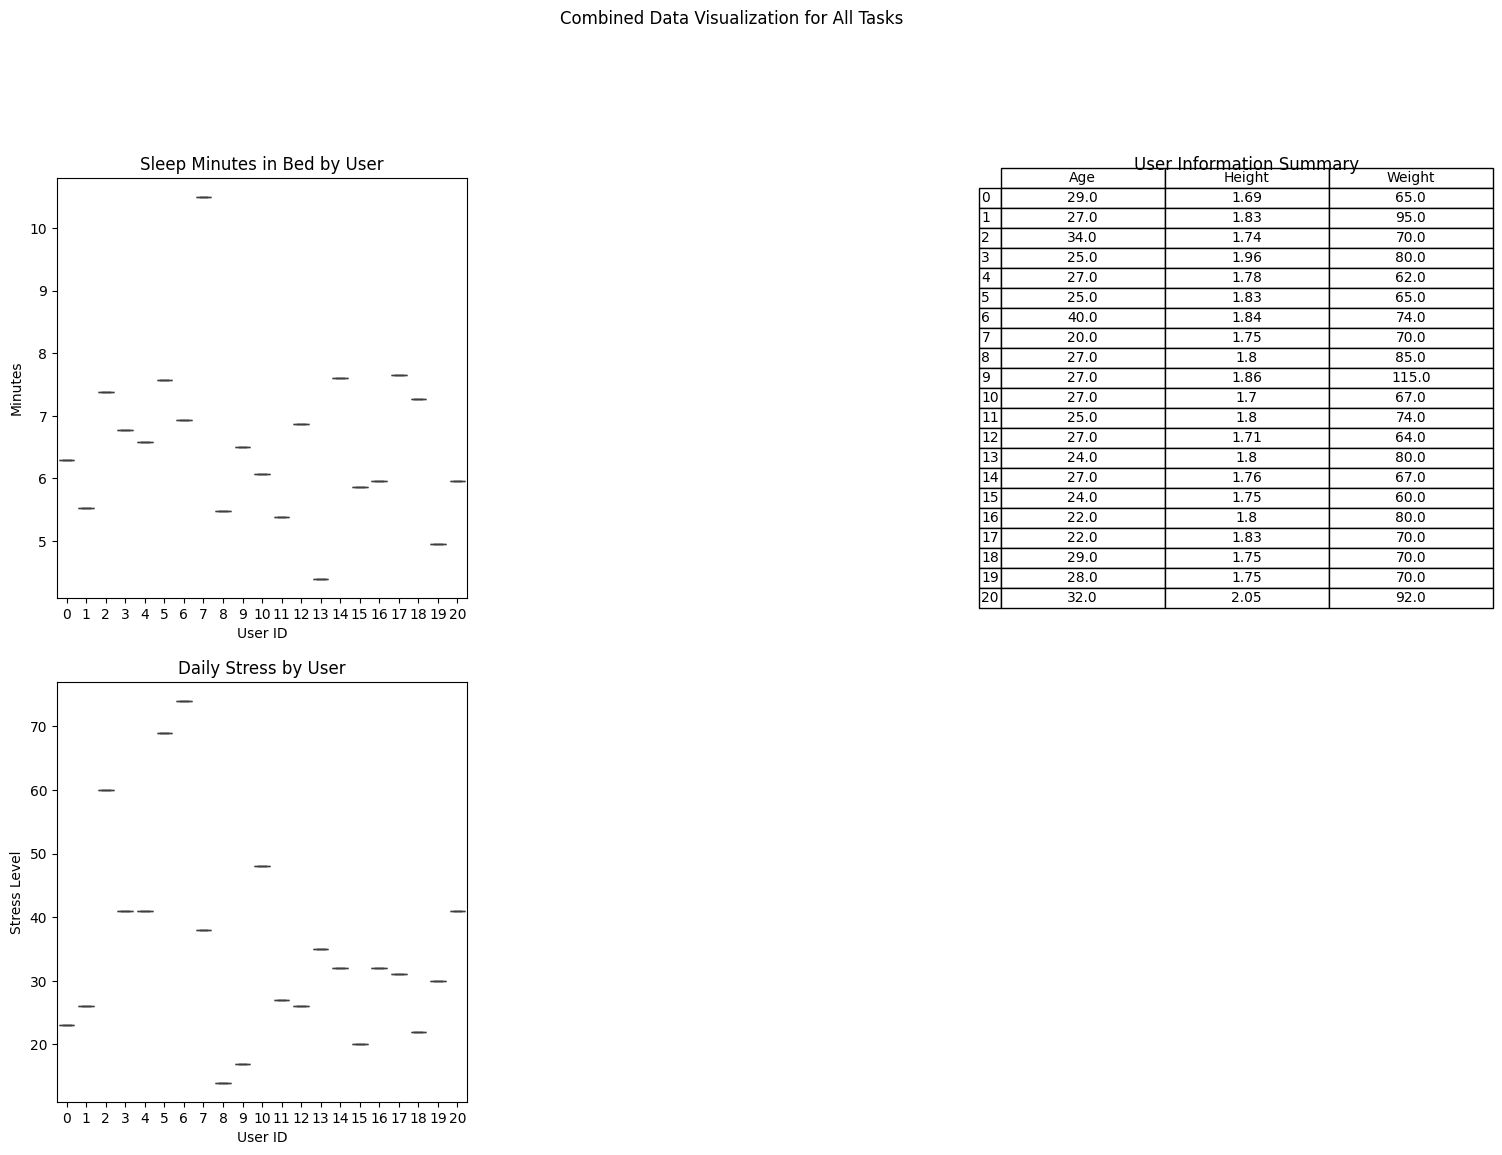

In [95]:
# tasks = [i for i in TASKS if i not in OMIT_TASKS]
TASKS = range(0, 21)
tasks = [i for i in TASKS]
mmash = MMASH(t_list, X_train_list, S_train_list, Y_train_list ,tasks, max_zscore=2.5)

# PhysioMTL Model Definition

In [106]:
T_GRADIENT_THRESHOLD = 1e-8
W_GRADIENT_THRESHOLD = 1e-7
# COST_FUNC = lambda x, y: np.sqrt(np.mean(np.square(np.dot([1, 10., 1., 10, 1., 1.], x - y))))
COST_FUNC = lambda x, y: np.sqrt(np.mean(np.square(
    np.dot([1., 10., 1., 10., 1., 1.], (x - y).flatten()[:6]))))

In [107]:
T_GRADIENT_THRESHOLD = 1e-8
W_GRADIENT_THRESHOLD = 1e-7
random.seed(1)
COST_FUNC = lambda x, y: np.sqrt(np.mean(np.square(np.dot([1, 10., 1., 10, 1., 1.], x - y))))
class PhysioMTL:
    def __init__(self, cost_func, iterations=50, t_learn_rate=0.09, t_iterations=200, w_learn_rate=1e-7, w_iterations=50, alpha=0.1, epsilon=1e-4, lambda_=5, sigma=10, verbose=False):
        self.cost_func = cost_func
        self.iterations = iterations
        self.t_learn_rate = t_learn_rate
        self.t_iterations = t_iterations
        self.w_learn_rate = w_learn_rate
        self.w_iterations = w_iterations
        self.alpha = alpha
        self.epsilon = epsilon
        self.lambda_ = lambda_
        self.sigma = sigma
        self.verbose = verbose

    def fit(self, X, S, Y):
        self.start_fit_cycles = count()
        self.S = S
        W = self.solve_w_by_linear_regression(X, Y)
        C, K = self.get_cost_matrix(S)
        Pi = self.solve_ot_plan(C)
        self.coef_ = self.W, self.T = self.converge_fw_gradient_descent(X, Y, W, K, Pi)
        self.end_fit_cycles = count_end() - self.start_fit_cycles
        if self.verbose:
          print(f'PhysioMTL fit completed in {self.end_fit_cycles} cycles ({get_cpu_seconds(self.end_fit_cycles)} seconds)')

    def solve_w_by_linear_regression(self, X, Y):
        # print(f'============== x shape is {X.shape}')
        # print(f'============== Y shape is {Y.shape}')
        return np.concatenate([Y[i].T @ x @ np.linalg.inv(x.T @ x) for i, x in enumerate(X)]).T

    def get_cost_matrix(self, S):
        C = np.asarray([[self.cost_func(i, j) for j in S] for i in self.S])
        K = np.exp(-C / (2 * self.sigma**2))
        return C, K

    def solve_ot_plan(self, C):
        T = len(C)
        fracs = np.ones(T) / T
        transport_matrix = np.exp(-self.lambda_ * C)
        transport_matrix /= transport_matrix.sum()
        u = np.zeros(T)
        while np.max(np.abs(u - transport_matrix.sum(1))) > self.epsilon:
            u = transport_matrix.sum(1)
            transport_matrix *= fracs / u[:, None]
            transport_matrix *= fracs / transport_matrix.sum(0)[None, :]
        return transport_matrix

    def converge_fw_gradient_descent(self, X, Y, W, K, Pi):
        N = len(X)
        Z = np.zeros((W.shape[0], K.shape[0]))
        T = np.zeros((W.shape[0], K.shape[0]))
        for iteration in range(self.iterations):
            norm_last = 1e6
            for t in range(self.t_iterations):
                grad = [Pi[i, j] * (W[:, i:i+1] - T @ K[:, j:j+1]) @ K[:, j:j+1].T for i in range(N) for j in range(N)]
                grad = Z - self.alpha * 2 * sum(grad)
                norm = np.sum(np.square(grad))
                if np.abs(norm_last - norm) < T_GRADIENT_THRESHOLD:
                    break
                norm_last = norm
                T = T - self.t_learn_rate * grad
            #print(iteration, ": T gradient F-norm:", norm)

            norm_last = 1e6
            for w in range(self.w_iterations):
                grad = np.zeros_like(W)
                for t in range(N):
                    grad[:, t:t+1] = ((W[:, t:t+1].T @ X[t].T - Y[t].T) @ (X[t]) - self.alpha * sum([(T @ K[:, tt:tt+1] - W[:, tt:tt + 1]).T for tt in range(N)])).T
                norm = np.sum(np.square(grad))
                if np.abs(norm_last - norm) < W_GRADIENT_THRESHOLD:
                    break
                norm_last = norm
                W = W - self.w_learn_rate * grad
        return W, T

    def predict(self, X, S):
        self.start_predict_cycles = count()
        if X is None and S is None:
            return [x @ self.W[:, i:i+1] for i, x in enumerate(self.X)]

        _, K = self.get_cost_matrix(S)
        K = [K[:, i:i+1] for i in range(len(S))]
        self.end_predict_cycles = count_end() - self.start_predict_cycles
        if self.verbose:
            print(f'PhysioMTL predict completed in {self.end_predict_cycles} cycles ({get_cpu_seconds(self.end_predict_cycles)} seconds)')

        return [x @ self.T @ K[i] for i, x in enumerate(X)]

## Train the model

In [98]:
model = PhysioMTL(COST_FUNC, verbose=True)
model.fit(mmash.X, mmash.S, mmash.Y)

PhysioMTL fit completed in 92709142380 cycles (46.35457119 seconds)


## Toy Sample PhysioMTL Prediction

PhysioMTL predict completed in 910577 cycles (0.0004552885 seconds)


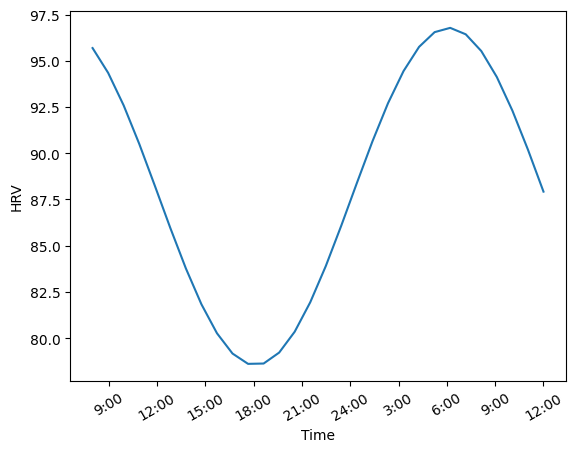

In [99]:
S_ = np.array([23., 1.80, 85., 1., 7., 20.]).reshape(-1, 1)

T_ = np.linspace(8, 36, 30)
X_ = np.asarray([np.sin(RAD_HOUR * T_), np.cos(RAD_HOUR * T_), np.ones(30, )]).T

_, ax = plt.subplots()

ticks = [[9, '9:00'], [12, '12:00'], [15, '15:00'], [18, '18:00'], [21, '21:00'], [24, '24:00'], [27, '3:00'], [30, '6:00'], [33, '9:00'], [36, '12:00']]
ax.set_xticks([x[0] for x in ticks])
ax.set_xticklabels([x[1] for x in ticks], rotation=30)
ax.set_ylabel("HRV")
ax.set_xlabel("Time")

ax.plot(T_, model.predict([X_], [S_])[0])


# Model Performance

## Evaluation Methods

In [144]:
def evaluate_all_percentages(X, S, Y, percentages, compare_alpha=0.9, physio_alpha=0.1, iterations=20, cost_func=COST_FUNC):
    for p in percentages:
        start_evaluation_time = count()
        evaluate_all(X, S, Y, p, compare_alpha, physio_alpha, iterations, cost_func)
        end_evaluation_time = count_end() - start_evaluation_time
        print('    Evaluation:')
        print(f'         iterations: {iterations}')
        print(f'         elapsed time: {end_evaluation_time} cycles ({get_cpu_seconds(end_evaluation_time)} seconds)')
        print('')

def evaluate_all(X, S, Y, percentage, compare_alpha, physio_alpha, iterations, cost_func):
    mse_physio = []
    mse_glasso = []
    mse_mlasso = []
    mse_dirty = []
    mse_mtw = []
    mse_remtw = []

    for _ in range(iterations):
        cutoff = int(percentage * len(S))
        idx = list(range(0, len(S)))
        random.shuffle(idx)
        train_index, test_index = idx[:cutoff], idx[cutoff:]
        # print(f's is {len(S)}, cutoff is {cutoff}, idx is {idx}, train_index is {train_index}')
        X_train = [X[i] for i in train_index]
        S_train = [S[i] for i in train_index]
        Y_train = [Y[i] for i in train_index]
        X_test = [X[i] for i in test_index]
        S_test = [S[i] for i in test_index]
        Y_test = [Y[i] for i in test_index]

        if physio_alpha:
            model = PhysioMTL(cost_func, alpha=physio_alpha, verbose=False)
            model.fit(np.asarray(X_train, dtype=object), np.asarray(S_train,dtype=object), np.asarray(Y_train, dtype=object))
            preds = model.predict(np.asarray(X_test, dtype=object), np.asarray(S_test, dtype=object))
            mse_physio.append(get_rmse(preds, np.asarray(Y_test,dtype=object)))

        x = np.zeros((len(X_train), 100, 3 + 6))
        y = np.zeros((len(X_train), 100))
        for i, s in enumerate(S_train):
            idx = list(range(0, X_train[i].shape[0]))
            random.shuffle(idx)
            x[i:i+1, :, 0:3] = X_train[i][idx[:100]]
            y[i:i+1, :] = Y_train[i][idx[:100]].reshape((1, -1))
            x[i:i+1, :, 3:] = s.reshape((1, -1))

        if compare_alpha:
            grouplasso_mse = get_mse(GroupLasso(alpha=compare_alpha), x, y, S_train, X_test, S_test, Y_test, cost_func)
            mllasso_mse = get_mse(MultiLevelLasso(alpha=compare_alpha), x, y, S_train, X_test, S_test, Y_test, cost_func)
            dirty_mse = get_mse(DirtyModel(alpha=compare_alpha), x, y, S_train, X_test, S_test, Y_test, cost_func)
            mtw_mse = get_mse(MTW(alpha=compare_alpha), x, y, S_train, X_test, S_test, Y_test, cost_func)
            remtw_mse = get_mse(ReMTW(alpha=compare_alpha), x, y, S_train, X_test, S_test, Y_test, cost_func)

            mse_glasso.append(grouplasso_mse)
            mse_mlasso.append(mllasso_mse)
            mse_dirty.append(dirty_mse)
            mse_mtw.append(mtw_mse)
            mse_remtw.append(remtw_mse)

    print(f'{percentage*100}% (alpha {compare_alpha} vs {physio_alpha})')
    if compare_alpha:
        print(f'    Group Lasso:  {np.mean(mse_glasso)} ± {np.std(mse_glasso)}')
        print(f'    MLevel Lasso: {np.mean(mse_mlasso)} ± {np.std(mse_mlasso)}')
        print(f'    Dirty Model:  {np.mean(mse_dirty)} ± {np.std(mse_dirty)}')
        print(f'    MT Was:       {np.mean(mse_mtw)} ± {np.std(mse_mtw)}')
        print(f'    MT Was Rewgt: {np.mean(mse_remtw)} ± {np.std(mse_remtw)}')
    if physio_alpha:
        print(f'    PhysioMTL:    {np.mean(mse_physio)} ± {np.std(mse_physio)}')

def get_rmse(a, b):
    return sum([np.sqrt(np.mean(np.square(a[i] - b[i]))) for i in range(len(a))]) / len(a)

def get_mse(model, X_train, Y_train, S_train, X_test, S_test, Y_test, cost_func):
    model.fit(X_train, Y_train)
    y = []
    for i, s_test in enumerate(S_test):
        cost_array = []
        for s in S_train:
          cost = cost_func(s, s_test)
          cost_array.append((cost, s))

        # cost_array = np.asarray(cost_array)
        # idx = np.argsort(cost_array)

        idx = []
        # for _, top_cost in sorted((cost_func(s, s_test), s) for s in S_train)[:1]:
        # print(cost_array)
        # print("###################")
        # print(sorted(cost_array))
        for  _, top_cost in sorted(cost_array, key=lambda x: (x[0], tuple(x[1].flatten())))[:1]:
          for j, s_train in enumerate(S_train):
              if np.max(s_train - top_cost) < 1e-6:
                  idx.append(j)
                  break

        X = np.zeros((len(X_test[i]), 9))
        X[:, 0:3] = X_test[i]
        X[:, 3:] = s_test.reshape((1, -1))
        y.append(X @ model.coef_[:, idx] + np.median(Y_train))

    return get_rmse(y, Y_test)

## Original Evaluation

In [145]:
evaluate_all_percentages(mmash.X, mmash.S, mmash.Y, percentages=[0.2, 0.4, 0.6, 0.8])

20.0% (alpha 0.9 vs 0.1)
    Group Lasso:  31.85582224888905 ± 1.6472615064091065
    MLevel Lasso: 32.00704185753123 ± 1.6284221207358267
    Dirty Model:  31.854754083517395 ± 1.647959727317743
    MT Was:       31.37530266062372 ± 1.791142454172698
    MT Was Rewgt: 31.39734695407727 ± 1.7858361297838636
    PhysioMTL:    30.953728687441888 ± 1.5293950456854786
    Evaluation:
         iterations: 20
         elapsed time: 101715085982 cycles (50.857542991 seconds)

40.0% (alpha 0.9 vs 0.1)
    Group Lasso:  31.337234328206854 ± 1.597122575827105
    MLevel Lasso: 31.440225663578207 ± 1.5909380844813672
    Dirty Model:  31.33724461867605 ± 1.5971173181521447
    MT Was:       30.832357067970054 ± 1.6620027857181439
    MT Was Rewgt: 30.853896869676475 ± 1.659650369391262
    PhysioMTL:    29.923010360917345 ± 1.053396169316763
    Evaluation:
         iterations: 20
         elapsed time: 312973256266 cycles (156.486628133 seconds)

60.0% (alpha 0.9 vs 0.1)
    Group Lasso:  32.075

#Conterfactual Analysis

PhysioMTL predict completed in 811960 cycles (0.00040598 seconds)
PhysioMTL predict completed in 792965 cycles (0.0003964825 seconds)
PhysioMTL predict completed in 824339 cycles (0.0004121695 seconds)
PhysioMTL predict completed in 696767 cycles (0.0003483835 seconds)
PhysioMTL predict completed in 694998 cycles (0.000347499 seconds)
PhysioMTL predict completed in 700506 cycles (0.000350253 seconds)
PhysioMTL predict completed in 752847 cycles (0.0003764235 seconds)
PhysioMTL predict completed in 812338 cycles (0.000406169 seconds)
PhysioMTL predict completed in 759369 cycles (0.0003796845 seconds)
PhysioMTL predict completed in 804051 cycles (0.0004020255 seconds)
PhysioMTL predict completed in 695445 cycles (0.0003477225 seconds)
PhysioMTL predict completed in 854698 cycles (0.000427349 seconds)
PhysioMTL predict completed in 760084 cycles (0.000380042 seconds)
PhysioMTL predict completed in 896294 cycles (0.000448147 seconds)
PhysioMTL predict completed in 1424549 cycles (0.0007122

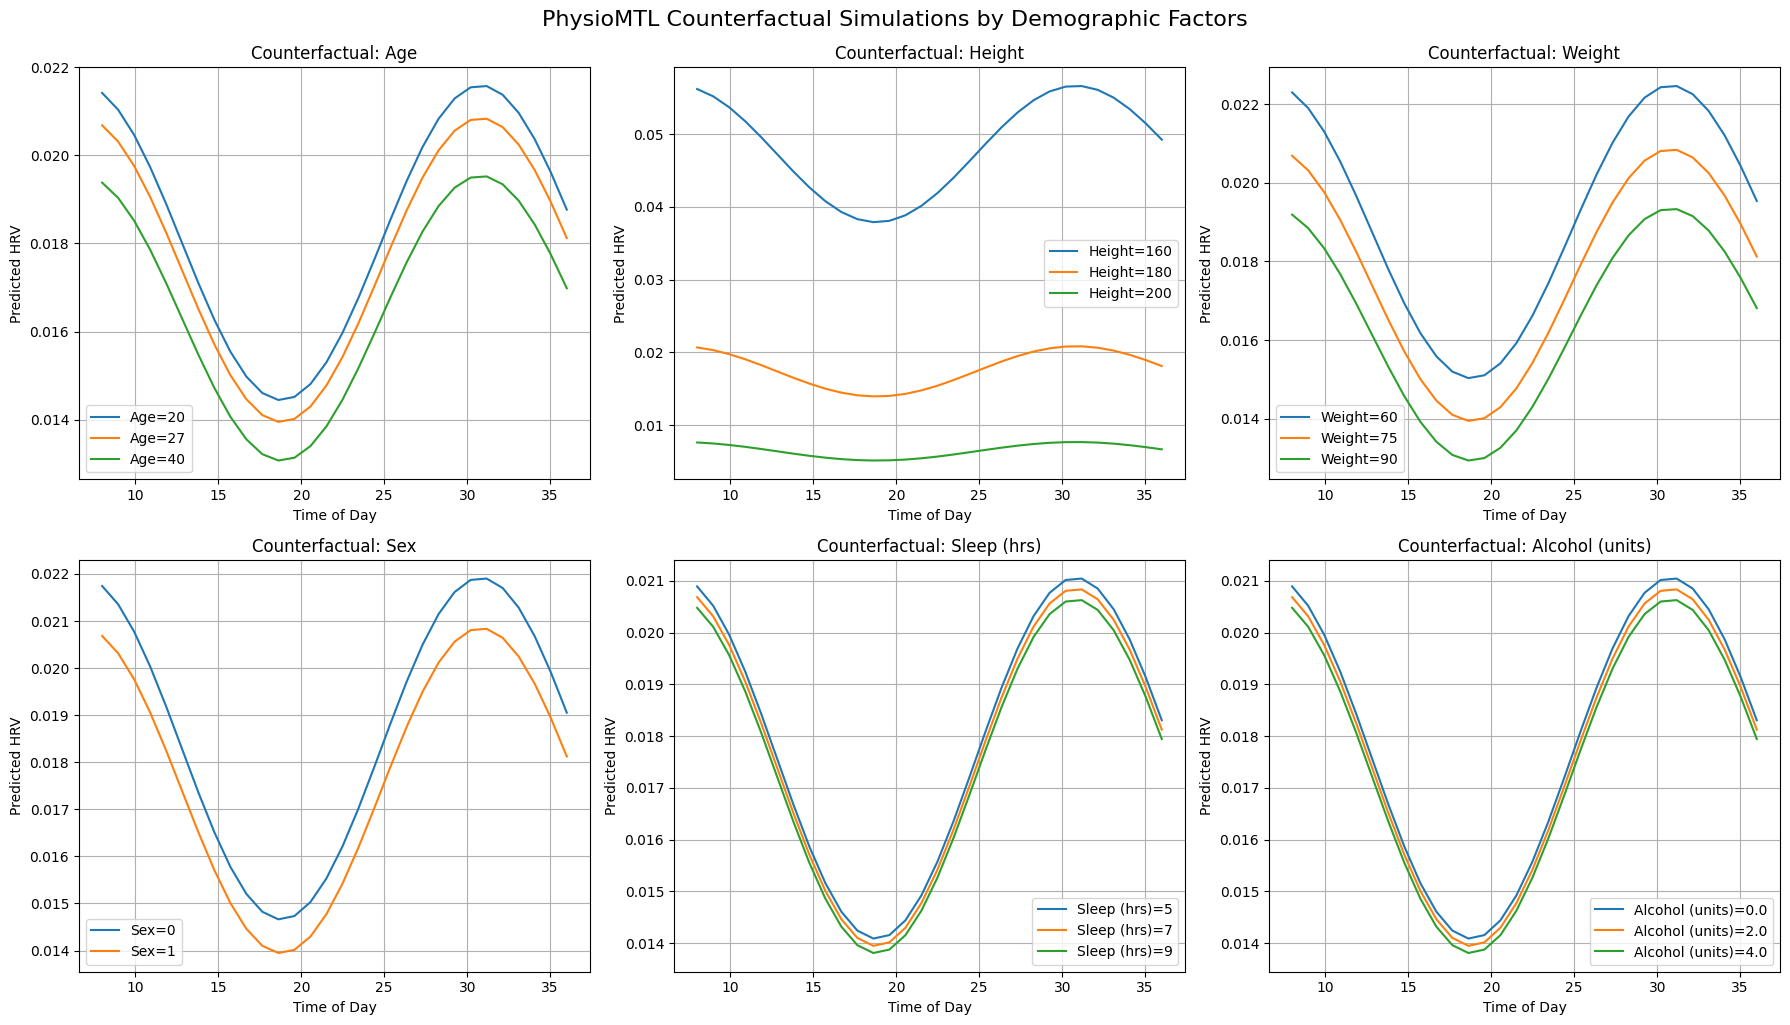

In [146]:
import numpy as np
import matplotlib.pyplot as plt

RAD_HOUR = 2.0 * np.pi / 24
T_ = np.linspace(8, 36, 30)
X_ = np.asarray([np.sin(RAD_HOUR * T_), np.cos(RAD_HOUR * T_), np.ones(30)]).T

# Baseline demographic vector (you can change to any subject)
S_baseline = np.array([27, 180, 75, 1, 7, 2.0]).reshape(-1, 1)

# Attributes to vary: (index, name, values)
demographic_variations = [
    (0, "Age", [20, 27, 40]),
    (1, "Height", [160, 180, 200]),
    (2, "Weight", [60, 75, 90]),
    (3, "Sex", [0, 1]),  # 0 = female, 1 = male
    (4, "Sleep (hrs)", [5, 7, 9]),
    (5, "Alcohol (units)", [0.0, 2.0, 4.0]),
]

# Plot setup
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()

for idx, (attr_idx, attr_name, values) in enumerate(demographic_variations):
    ax = axs[idx]
    for v in values:
        S_var = S_baseline.copy()
        S_var[attr_idx, 0] = v
        y_pred = model.predict([X_], [S_var])[0]
        ax.plot(T_, y_pred, label=f"{attr_name}={v}")
    ax.set_title(f"Counterfactual: {attr_name}")
    ax.set_xlabel("Time of Day")
    ax.set_ylabel("Predicted HRV")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.suptitle("PhysioMTL Counterfactual Simulations by Demographic Factors", fontsize=16, y=1.02)
plt.show()


## Enhance interpretability using Attention and SHAP

In [33]:
np.array([mmash.Y[0]]).shape

(1, 226, 1)

In [147]:
import numpy as np
import matplotlib.pyplot as plt
import shap

# --------------------------
# Assume your PhysioMTL model is already loaded and trained: model
# Assume RAD_HOUR = np.pi / 12 (since 24 hours → 2π rad)
RAD_HOUR = 2.0 * np.pi / 24

# 1. Define input X_ (sin, cos, constant over time)
T_ = np.linspace(8, 36, 30)  # 30 time points from 8 AM to 12 PM next day
# X_ = np.asarray([
#     np.sin(RAD_HOUR * T_),
#     np.cos(RAD_HOUR * T_),
#     np.ones(30,)
# ]).T  # shape (30, 3)
X_ = np.asarray([mmash.X[0]], dtype=object)


# 2. Define original and counterfactual demographics S
# [age, height (m), weight (kg), sex (1=male, 0=female), sleep hours, alcohol consumption units]
S_original = np.asarray([mmash.S[0]], dtype=object)  # 7h sleep
print(S_original)
S_counterfactual = S_original.copy()
S_counterfactual[0, 4, 0] = 4.  # Less sleep: 4h
print(S_counterfactual
      )
# 3. Predict original and counterfactual HRV curves
y_original = model.predict([X_], [S_original])[0]
y_counterfactual = model.predict([X_], [S_counterfactual])[0]

# print(y_original)
# print(y_counterfactual)

# --------------------------
# 4. Get effective attention

def get_effective_attention(model, S_batch):
    _, K = model.get_cost_matrix(S_batch)
    attention_vec = np.abs(model.T @ K)  # shape (3, 1)
    attention_vec /= attention_vec.sum(axis=0, keepdims=True)  # normalize
    return attention_vec

attn_original = get_effective_attention(model, [S_original])
attn_counterfactual = get_effective_attention(model, [S_counterfactual])

# --------------------------
# 5. Get SHAP values

class PhysioMTLWrapper:
    def __init__(self, model, S_input, X_batch):
        self.model = model
        self.S_input = S_input
        self.X_input = X_batch

    def predict(self, X_batch):
        preds = self.model.predict(self.X_input, self.S_input)
        print('here is the preds', np.array(preds[0]).flatten())
        return np.array(preds[0]).flatten()

# Explainers
print(X_.shape)
explainer_orig = shap.KernelExplainer(PhysioMTLWrapper(model, S_original).predict, X_)
shap_values_orig = explainer_orig.shap_values(X_)

explainer_cf = shap.KernelExplainer(PhysioMTLWrapper(model, S_counterfactual, X_).predict, X_)
shap_values_cf = explainer_cf.shap_values(X_)

# --------------------------
# 6. Plot HRV curves

fig, ax = plt.subplots(figsize=(10, 5))

ticks = [[9, '9:00'], [12, '12:00'], [15, '15:00'], [18, '18:00'], [21, '21:00'],
         [24, '24:00'], [27, '3:00'], [30, '6:00'], [33, '9:00'], [36, '12:00']]
ax.set_xticks([x[0] for x in ticks])
ax.set_xticklabels([x[1] for x in ticks], rotation=30)
ax.set_ylabel("HRV")
ax.set_xlabel("Time")

ax.plot(T_, y_original, label="Original (7h sleep)")
ax.plot(T_, y_counterfactual, label="Counterfactual (4h sleep)", linestyle="--")

ax.legend()
plt.title("Counterfactual HRV Prediction (Sleep Reduction)")
plt.grid(True)
plt.show()

# --------------------------
# 7. Plot Attention and SHAP differences

feature_names = ['sin(time)', 'cos(time)', 'constant']

def plot_attention_shap_change(attn_orig, attn_cf, shap_orig, shap_cf, feature_names):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Attention delta
    attn_delta = (attn_cf - attn_orig).flatten()
    axs[0].barh(feature_names, attn_delta)
    axs[0].set_title("Attention Change (Counterfactual - Original)")
    axs[0].axvline(0, color='gray')

    # SHAP delta
    shap_orig_mean = np.abs(shap_orig).mean(axis=0)
    shap_cf_mean = np.abs(shap_cf).mean(axis=0)
    shap_delta = shap_cf_mean - shap_orig_mean
    axs[1].barh(feature_names, shap_delta)
    axs[1].set_title("SHAP Value Change (Counterfactual - Original)")
    axs[1].axvline(0, color='gray')

    plt.tight_layout()
    plt.show()

# Call plot
plot_attention_shap_change(attn_original, attn_counterfactual, shap_values_orig, shap_values_cf, feature_names)


[[[29.0]
  [1.69]
  [65.0]
  [0.3333333333333333]
  [6.3]
  [23.0]]]
[[[29.0]
  [1.69]
  [65.0]
  [0.3333333333333333]
  [4.0]
  [23.0]]]
PhysioMTL predict completed in 1106602 cycles (0.000553301 seconds)
PhysioMTL predict completed in 1030636 cycles (0.000515318 seconds)
(1, 226, 3)


TypeError: PhysioMTLWrapper.__init__() missing 1 required positional argument: 'X_batch'